<a href="https://colab.research.google.com/github/Jkia65/Assignment-3-Python-Refresher/blob/main/Assignment_14.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 14: Ethical AI Analysis and Explainability

In [1]:
!pip install -q fairlearn shap lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 7.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.6/251.6 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 54.7 MB/s eta 0:00:00


# Step 1: Data Preparation

In [18]:
# Reqired all required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from lime.lime_tabular import LimeTabularExplainer


# Fairness analysis
from fairlearn.metrics import MetricFrame, selection_rate, false_positive_rate, true_positive_rate

# Explainability
import shap
import lime
import lime.lime_tabular

# Load Adult dataset
adult = fetch_openml("adult", version=2, as_frame=True)
df = adult.frame.copy()

# Target and Sensitive Attribute
TARGET = "class"        # income >50K or <=50K
SENSITIVE = "sex"       # fairness attribute

# Clean dataset: remove missing values
df = df.dropna().reset_index(drop=True)

# Convert target to binary (1 = >50K)
df["y"] = (df[TARGET] == ">50K").astype(int)

# Select features
features = [
    "age","workclass","education","marital-status",
    "occupation","race","sex","hours-per-week",
    "capital-gain","capital-loss","native-country"
]

X = df[features]
y = df["y"]
sensitive = df[SENSITIVE]

df.head()


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class,y
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K,0
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K,0
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K,1
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K,1
4,34,Private,198693,10th,6,Never-married,Other-service,Not-in-family,White,Male,0,0,30,United-States,<=50K,0


# Step 2: Model Training and Evaluation:


Accuracy: 0.8434436500331687

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.93      0.90     10205
           1       0.73      0.58      0.65      3362

    accuracy                           0.84     13567
   macro avg       0.80      0.76      0.77     13567
weighted avg       0.84      0.84      0.84     13567



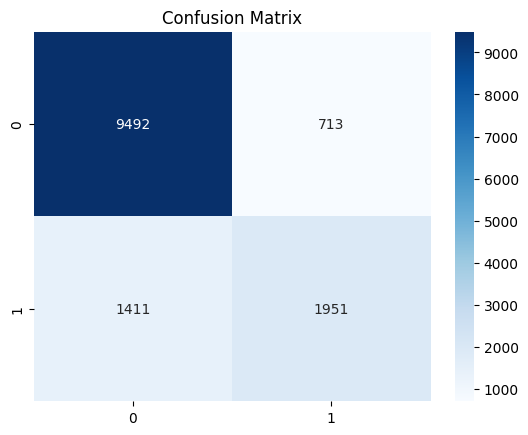

In [15]:
# Train/test split
X_train, X_test, y_train, y_test, sens_train, sens_test = train_test_split(
    X, y, sensitive, test_size=0.3, random_state=42, stratify=y
)

# Define preprocessing
numeric = ["age","hours-per-week","capital-gain","capital-loss"]
categorical = [c for c in features if c not in numeric]

preprocessor = ColumnTransformer([
    ("num", StandardScaler(), numeric),
    ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical)
])

# Build pipeline
model = Pipeline([
    ("prep", preprocessor),
    ("clf", LogisticRegression(max_iter=1000))
])

# Train model
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

Step 3: Fairness Analysis:



Fairness Metrics by Group:
        selection_rate  false_positive_rate  true_positive_rate
sex                                                            
Female        0.060312             0.013853            0.402647
Male          0.262254             0.104487            0.613484


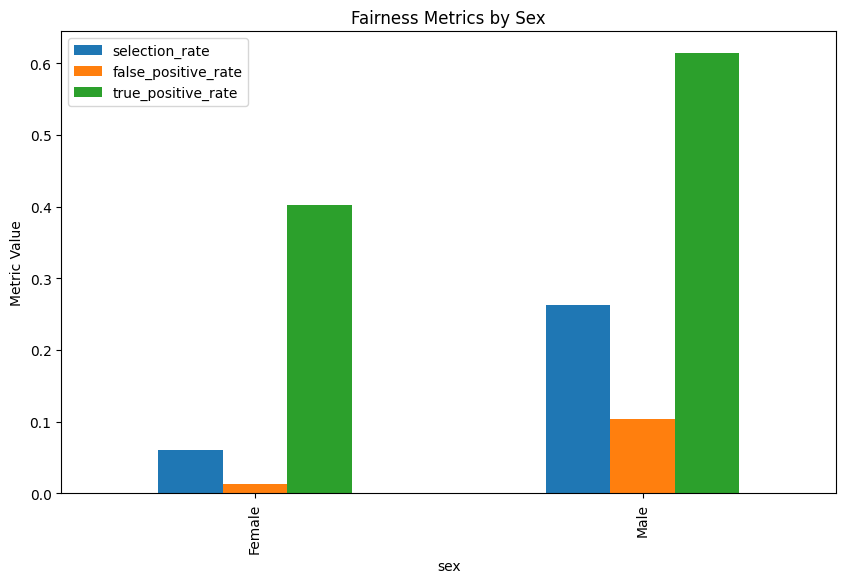

In [21]:
# STEP 3: FAIRNESS ANALYSIS

from fairlearn.metrics import MetricFrame
from fairlearn.metrics import selection_rate, false_positive_rate, true_positive_rate

# Define metrics
metrics = {
    "selection_rate": selection_rate,
    "false_positive_rate": false_positive_rate,
    "true_positive_rate": true_positive_rate,
}

metric_frame = MetricFrame(
    metrics=metrics,
    y_true=y_test,
    y_pred=y_pred,
    sensitive_features=sens_test
)

print("\nFairness Metrics by Group:")
print(metric_frame.by_group)

# Fairness Metrics Visualization by Sensitive Attribute (Sex)
metric_frame.by_group.plot(kind="bar", figsize=(10,6), title="Fairness Metrics by Sex")
plt.ylabel("Metric Value")
plt.show()


Step 4: Explainability Analysis


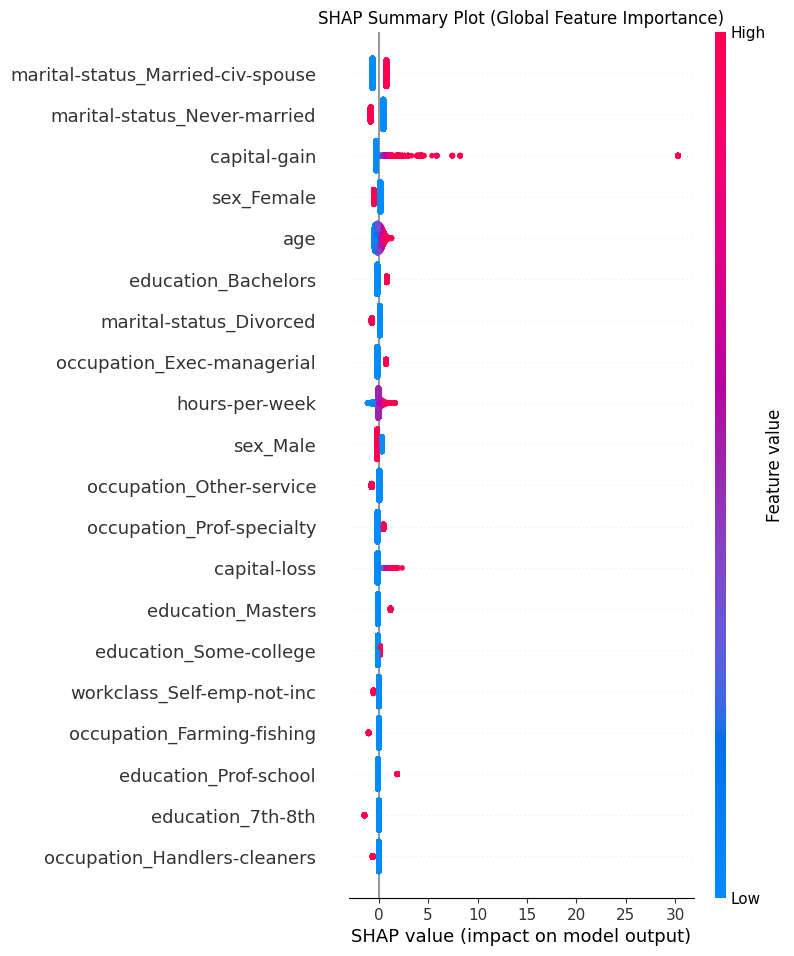

Local SHAP Explanation for test index: 5


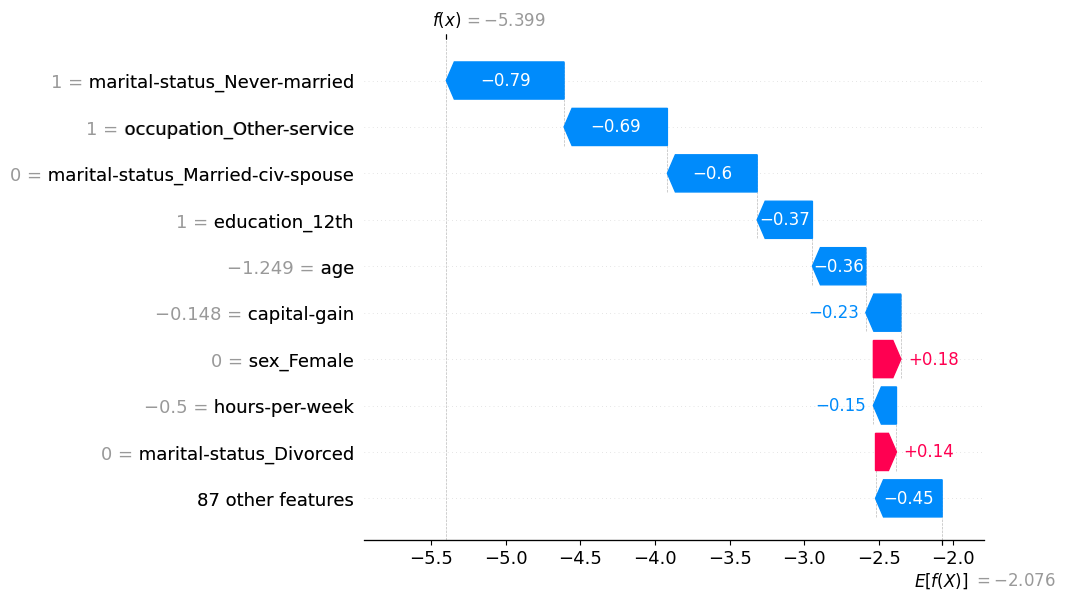


LIME Explanation for test index: 5


In [22]:
# Extract transformed feature names for SHAP
prep = model.named_steps["prep"]
ohe = prep.named_transformers_["cat"]
ohe_cols = list(ohe.get_feature_names_out(categorical))
feature_names = numeric + ohe_cols

# Transform the train and test sets
X_train_enc = prep.transform(X_train)
X_test_enc = prep.transform(X_test)


# SHAP Explainer (Global + Local)
import shap

# Initialize Linear SHAP explainer for logistic regression
explainer = shap.LinearExplainer(model.named_steps["clf"], X_train_enc)
shap_values = explainer.shap_values(X_test_enc)

# GLOBAL summary plot
shap.summary_plot(
    shap_values,
    X_test_enc,
    feature_names=feature_names,
    show=False
)
plt.title("SHAP Summary Plot (Global Feature Importance)")
plt.show()

# LOCAL explanation for a single instance
idx = 5
print("Local SHAP Explanation for test index:", idx)
shap.waterfall_plot(
    shap.Explanation(
        values=shap_values[idx],
        base_values=explainer.expected_value,
        data=X_test_enc[idx],
        feature_names=feature_names
    )
)


# LIME Explainer
from lime.lime_tabular import LimeTabularExplainer

# Use the encoded numeric data for LIME
lime_explainer = LimeTabularExplainer(
    training_data=X_train_enc,
    feature_names=feature_names,
    class_names=["<=50K", ">50K"],
    mode="classification"
)

lime_exp = lime_explainer.explain_instance(
    X_test_enc[idx],
    model.named_steps["clf"].predict_proba,
    num_features=8
)

print("\nLIME Explanation for test index:", idx)
lime_exp.show_in_notebook()